In [9]:
import torch
import time
from snn_delays.snn_refactored import SNN
from snn_delays.utils.dataset_loader import DatasetLoader
from snn_delays.utils.train_utils_refact_minimal import train, get_device, propagate_batch_simple
from snn_delays.utils.test_behavior import tb_save_max_acc_refac
import os
from snn_delays.config import DATASET_PATH
from snn_delays.datasets.custom_datasets import CustomDataset
from snn_delays.utils.memory_cached_dataset import MemoryCachedDataset
from torch.utils.data import DataLoader
import numpy as np

device = get_device()

#data = np.load(os.path.join(DATASET_PATH, 'raw_datasets', 'Letters', 'letter_classification_dataset.npz'))
data_C = np.load(os.path.join(DATASET_PATH, 'Capocaccia', 'C.npy'))
data_A = np.load(os.path.join(DATASET_PATH, 'Capocaccia', 'A.npy'))
data_P = np.load(os.path.join(DATASET_PATH, 'Capocaccia', 'P.npy'))
data_O = np.load(os.path.join(DATASET_PATH, 'Capocaccia', 'O.npy'))
data_I = np.load(os.path.join(DATASET_PATH, 'Capocaccia', 'I.npy'))

window_time = 10
n_chunks_train = int(0.8*data_O.shape[0] // window_time)
n_chunks_test = int(0.2*data_O.shape[0] // window_time)

end_train = n_chunks_train * window_time
end_test = end_train + n_chunks_test * window_time

# concatenate the data
train_data = np.concatenate((data_C[:end_train], data_A[:end_train], data_P[:end_train], 
                             data_O[:end_train], data_I[:end_train]), axis=0).squeeze()

test_data = np.concatenate((data_C[end_train:end_test], data_A[end_train:end_test], 
                            data_P[end_train:end_test], data_O[end_train:end_test], data_I[end_train:end_test]), axis=0).squeeze()

test_data = np.array(np.split(test_data, 5*n_chunks_test, axis=0))
train_data = np.array(np.split(train_data, 5*n_chunks_train, axis=0))

print(test_data.shape)
print(train_data.shape)

# create labels
train_labels = np.zeros((train_data.shape[0], 5))
test_labels = np.zeros((test_data.shape[0], 5))

for sample in range(train_data.shape[0]):
    idx = sample // n_chunks_train
    train_labels[sample, idx] = 1

for sample in range(test_data.shape[0]):
    idx = sample // n_chunks_test
    test_labels[sample, idx] = 1

num_samples = len(train_labels)

train_dataset = CustomDataset(train_data, train_labels)
test_dataset = CustomDataset(test_data, test_labels)

dataset_dict = train_dataset.get_train_attributes()

cached_train_dataset = MemoryCachedDataset(train_dataset, device=device)
cached_test_dataset = MemoryCachedDataset(test_dataset, device=device)

total_time = train_data.shape[1]
print(f'num timesteps per sample: {total_time}')

batch_size = 32

train_loader = DataLoader(cached_train_dataset,
                            batch_size=batch_size,
                            shuffle=True,
                            drop_last=False,
                            pin_memory=False,
                            num_workers=0)

test_loader = DataLoader(cached_test_dataset,
                            batch_size=batch_size,
                            shuffle=True,
                            drop_last=False,
                            pin_memory=False,
                            num_workers=0)

dataset_dict["dataset_name"] = "capo_single"
dataset_dict["num_input"] = 2*128*128

Running on: cuda:0


(895, 10, 2, 128, 128)
(3595, 10, 2, 128, 128)
Initializing GPU cache for 3595 samples...
Cache initialized in 0.56 seconds
Initializing GPU cache for 895 samples...
Cache initialized in 0.44 seconds
num timesteps per sample: 10


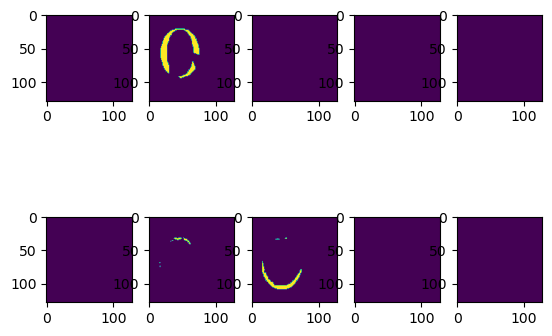

In [98]:
import matplotlib.pyplot as plt

for x in range(10):
    plt.subplot(2, 5, x+1)
    plt.imshow(test_data[700, x, 0, :, :])


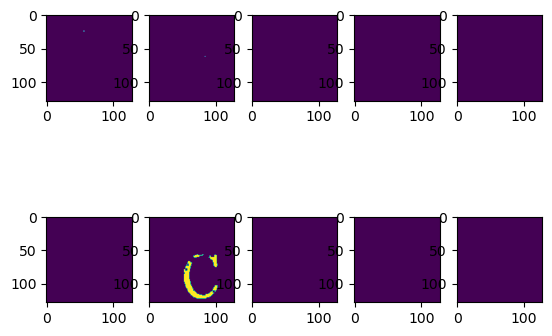

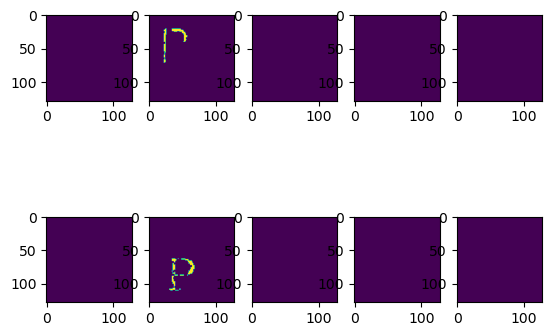

tensor([[1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0.]], device='cuda:0', dtype=torch.float64)


In [99]:
for img, l in train_loader:
    for b in range(2): # 2 elements of the same batch
        for x in range(10):
            plt.subplot(2, 5, x+1)
            plt.imshow(img[b, x, 0, :, :].cpu().numpy())
        plt.show()
    print(l[:2])
    break

In [100]:
dataset_dict

{'num_input': 32768,
 'num_training_samples': 3595,
 'num_output': 5,
 'dataset_name': 'capo_single'}

In [ ]:
ckpt_dir = 'capocaccia_homog_tau'

structure = (64, 3, 'f')
extra_kwargs = {}

snn = SNN(dataset_dict=dataset_dict, structure=structure, tau_m='log-uniform', win=window_time, loss_fn='mem_sum', batch_size=batch_size, device=device, 
          **extra_kwargs)

snn.input2spike_th = 0.01

snn.model_name = 'capo1_f'
snn.set_layers()
snn.to(device)
print(snn)

num_epochs = 50
lr = 1e-3
train(snn, train_loader, test_loader, lr, num_epochs, ckpt_dir=ckpt_dir, test_behavior=tb_save_max_acc_refac, scheduler=(10, 0.95), test_every=1)


SNN(
  (criterion): CrossEntropyLoss()
  (layers): ModuleList(
    (0): FeedforwardSNNLayer(
      (linear): Linear(in_features=32768, out_features=64, bias=False)
    )
    (1-2): 2 x FeedforwardSNNLayer(
      (linear): Linear(in_features=64, out_features=64, bias=False)
    )
    (3): FeedforwardSNNLayer(
      (linear): Linear(in_features=64, out_features=5, bias=False)
    )
  )
)
Epoch [1/50], learning_rates 0.001000, 0.100000


c:\Users\Alberto\anaconda3\envs\deepsnn\Lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Step [37/112], Loss: 1.48101
Step [74/112], Loss: 1.44209
Step [111/112], Loss: 1.06684
Time elasped: 5.6545116901397705
895
Test Loss: 1.2990665691239494
Avg spk_count per neuron for all 10 time-steps 49.47486033519554
Test Accuracy of the model on the test samples: 46.704

saving max acc: 46.70391061452514
Model saved in  C:\Users\Alberto\OneDrive - UNIVERSIDAD DE SEVILLA\PythonData\Checkpoints\capocaccia
Epoch [2/50], learning_rates 0.001000, 0.100000
Step [37/112], Loss: 1.17261
Step [74/112], Loss: 1.24819
Step [111/112], Loss: 1.01703
Time elasped: 5.683683395385742
895
Test Loss: 1.200328835419246
Avg spk_count per neuron for all 10 time-steps 46.81005586592178
Test Accuracy of the model on the test samples: 52.291

saving max acc: 52.29050279329609
Model saved in  C:\Users\Alberto\OneDrive - UNIVERSIDAD DE SEVILLA\PythonData\Checkpoints\capocaccia
Epoch [3/50], learning_rates 0.001000, 0.100000
Step [37/112], Loss: 1.26139
Step [74/112], Loss: 1.09299
Step [111/112], Loss: 0.91

In [11]:
snn_rnn = SNN(dataset_dict, structure=(64, 2, 'r'), win=window_time, tau_m='log-uniform',
               loss_fn='mem_sum', batch_size=batch_size, device=device, debug=False)

snn_rnn.set_layers()
snn_rnn.to(device)

snn_rnn.model_name = 'capo1_r'

print(snn_rnn)
train(snn_rnn, train_loader, test_loader, lr, num_epochs,  ckpt_dir=ckpt_dir, test_behavior=tb_save_max_acc_refac, scheduler=(10, 0.95), test_every=1)



SNN(
  (criterion): CrossEntropyLoss()
  (layers): ModuleList(
    (0): RecurrentSNNLayer(
      (linear): Linear(in_features=32768, out_features=64, bias=False)
      (linear_rec): Linear(in_features=64, out_features=64, bias=False)
    )
    (1): RecurrentSNNLayer(
      (linear): Linear(in_features=64, out_features=64, bias=False)
      (linear_rec): Linear(in_features=64, out_features=64, bias=False)
    )
    (2): FeedforwardSNNLayer(
      (linear): Linear(in_features=64, out_features=5, bias=False)
    )
  )
)
Epoch [1/50], learning_rates 0.001000, 0.100000
Step [37/112], Loss: 1.49682
Step [74/112], Loss: 1.29511
Step [111/112], Loss: 1.40451
Time elasped: 9.065011978149414
895
Test Loss: 1.1838918349572591
Avg spk_count per neuron for all 10 time-steps 69.12960893854749
Test Accuracy of the model on the test samples: 53.966

saving max acc: 53.96648044692738
Model saved in  C:\Users\Alberto\OneDrive - UNIVERSIDAD DE SEVILLA\PythonData\Checkpoints\capocaccia
Epoch [2/50], learn

In [12]:
extra_kwargs = {'delay_range':(10, 1),
                'pruned_delays': 3}

snn_rd = SNN(dataset_dict, structure=(64, 2, 'd'), win=window_time, tau_m='log-uniform',
               loss_fn='mem_sum', batch_size=batch_size, device=device, debug=False, **extra_kwargs)

snn_rd.set_layers()
snn_rd.to(device)

snn_rd.model_name = 'capo1_d'

print(snn_rd)
train(snn_rd, train_loader, test_loader, lr, num_epochs,  ckpt_dir=ckpt_dir, test_behavior=tb_save_max_acc_refac, scheduler=(10, 0.95), test_every=1)

SNN(
  (criterion): CrossEntropyLoss()
  (layers): ModuleList(
    (0): FeedforwardSNNLayer(
      (linear): Linear(in_features=32768, out_features=64, bias=False)
    )
    (1): FeedforwardSNNLayer(
      (linear): Linear(in_features=640, out_features=64, bias=False)
    )
    (2): FeedforwardSNNLayer(
      (linear): Linear(in_features=64, out_features=5, bias=False)
    )
  )
)
Epoch [1/50], learning_rates 0.001000, 0.100000
Step [37/112], Loss: 1.33902
Step [74/112], Loss: 1.26005
Step [111/112], Loss: 1.26138
Time elasped: 12.035204410552979
895
Test Loss: 1.1618833265134267
Avg spk_count per neuron for all 10 time-steps 69.76145251396647
Test Accuracy of the model on the test samples: 54.302

saving max acc: 54.30167597765363
Model saved in  C:\Users\Alberto\OneDrive - UNIVERSIDAD DE SEVILLA\PythonData\Checkpoints\capocaccia
Epoch [2/50], learning_rates 0.001000, 0.100000
Step [37/112], Loss: 0.83407
Step [74/112], Loss: 1.25036
Step [111/112], Loss: 1.02054
Time elasped: 9.00313